In [20]:
import numpy as np
from __future__ import division

%matplotlib inline
from matplotlib import pyplot as plt

from itertools import product

### Param settings

* $\texttt{NUM__SITES}$: number of loci of interest (let's also call it $l$)
* $N$: diploid population size
* $T$: number of generations
* $L$: list of lengths of distance between neighboring loci (i.e. $L = [d_{12},d_{23},\ldots,d_{(l-1)l}]$)
* $r$: rate at which recombination event happens at a given nucleotide per generation
* $s$: the selection coefficient. It is assumed that $s$ refers to the benefit of the $\lceil l/2 \rceil$th allele (define $l^* = \lceil l/2 \rceil$). 

In [111]:
NUM_SITES = 3
N=10000
T=300
L=[1000 for i in range(NUM_SITES-1)]
r=10**-8
s = 0.01
lStar = int((NUM_SITES+1)/2)
print(lStar)

2


In [115]:
trajs = []
#P = 1/(2**NUM_SITES) * np.ones(tuple(2 for i in range(NUM_SITES)))
P = np.array([[[0.025,0.02],            ###    ABC, ABc
             [0.6,0.15]],          ###    AbC, Abc
              [[0.02,0.03],          ###    aBC, aBc
              [0.15,0.005]]])         ###    abC, abc 

numr = 0
for t in range(T):
    ## reweight proportions P based on selective advantage
    tempP = P
    for index in np.ndindex(tuple(2 for i in range(NUM_SITES))):
        p = tempP[index]
        if index[lStar-1] == 0: 
            P[index] = p * (1+2*s*p+s*(1-p))/(1+2*s*p**2+2*s*p*(1-p))
        else:
            p = 1-p
            P[index] =  (1-p) * (1+s*p)/(1+2*s*p**2+2*s*p*(1-p))
    ## normalize
    P = 1/np.sum(P) * P
    
    ## sample/reproduce
    n = np.random.multinomial(N,P.flatten())

    ## generate chromosomes
    chroms = []
    for (k,j) in enumerate(n):
        P[tuple(int(i) for i in ''.join(['0' for i in range(NUM_SITES-len('{0:b}'.format(k)))]) + '{0:b}'.format(k))] = 1/N * j
        for l in range(j):
            chroms.append(''.join(['0' for i in range(NUM_SITES-len('{0:b}'.format(k)))]) + '{0:b}'.format(k))
    
    ## assort into pairs
    order = np.random.permutation(N)
    assert N % 2 == 0
    for m in range(int(N/2)):
        m = 2*m
        dip1 = order[m]
        dip2 = order[m+1]
            
        ## simulate recombinatione events
        ## crossover event simulation
        for (i,l) in enumerate(L):
            X = np.random.poisson(r*l)
            if X % 2 == 1:
                temp1 = chroms[dip1]
                temp2 = chroms[dip2]
                chroms[dip1] = temp1[0:(i+1)] + temp2[(i+1):]
                chroms[dip2] = temp2[0:(i+1)] + temp1[(i+1):]
        
    ## count chromosomes, update proportions
    P = np.zeros(tuple(2 for i in range(NUM_SITES)))
    for chrom in chroms:
        P[tuple(int(char) for char in chrom)] += 1/N

        
    trajs.append(P)    
    ## 



In [63]:
def margs(trajs,ax):
    marg = []
    for P in trajs:
        marg.append(np.sum(P,axis=tuple(i for i in range(NUM_SITES) if i != ax))[0])
    return marg

def r_squared(trajs,axes):
    r2 = []
    margA = margs(trajs,axes[0])
    margB = margs(trajs,axes[1])
    
    for (A,B,P) in zip(margA,margB,trajs):
        AB = np.sum(P,axis=tuple(i for i in range(NUM_SITES) if i != axes[0] and i != axes[1]))[0,0]
        r2.append( (AB - A*B) / ( A*(1-A)*B*(1-B) ) )
    return r2

In [47]:
import string

## Plotting marginal allele frequencies

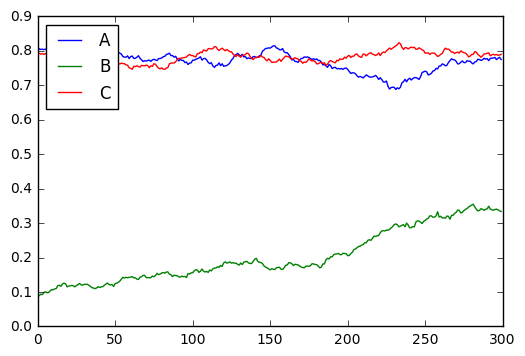

In [116]:
for (a,l) in zip(range(NUM_SITES),list(string.ascii_uppercase)[0:NUM_SITES]):
    plt.plot(range(T),margs(trajs,a),label=l)
plt.legend(loc=2)


### Plotting $R^2$ (measure of correlation/linkage disequilbrium)

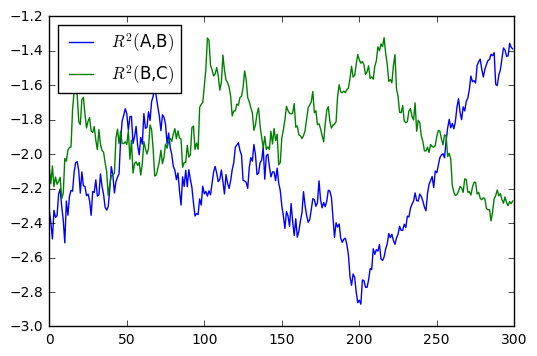

In [117]:
for (a,l1,l2) in zip(range(NUM_SITES-1),list(string.ascii_uppercase)[0:NUM_SITES-1],list(string.ascii_uppercase)[1:]):
    plt.plot(range(T),r_squared(trajs,[a,a+1]),label=r'$R^2($'+l1+','+l2+r'$)$')
plt.legend(loc=2)